In [5]:
# For performance (time, space used)
import time
import os
from sys import getsizeof

#
import operator

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import csv
import sys

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.stats import linregress
from scipy.stats.mstats import gmean
from scipy.stats import pearsonr

from pylab import rcParams
import seaborn as sb

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from collections import Counter


In [6]:
# Setup Data Paths 
rootPath = os.getcwd()
fileNameRealEstate = "Module1-RealEsttatePrices-Sale_Prices_County.csv"
fileNameIncome = "Module1-PersonalIncome-PCPI06037.csv"

csvFileRealEstate = os.path.join(rootPath, fileNameRealEstate)
csvFileIncome = os.path.join(rootPath, fileNameIncome)

In [7]:
#### Data Processing #######
# Setup

# Step 1 a).: Read in CSV file for Real Estate transactions
### Option 1 --- Read using Panadas library

#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
start1 = time.time()

csvFileRealEstateData = pd.read_csv(csvFileRealEstate)

end1 = time.time()


In [8]:
### Option 2 --- Read using CSV library

start2 = time.time()


with open(csvFileRealEstate, 'r') as csvfile:

    csvreader = csv.reader(csvfile)

    data =[]

    #next(csvreader)
    for row in csvreader:
        data.append(row)    

end2 = time.time()

In [9]:
%matplotlib inline

#### You will not need to do this in the real world ---- but to 'peak' under the hood
type(csvFileRealEstateData) # Data Frame
timeDifference1 = end1-start1
sizeOf1 = getsizeof(csvFileRealEstateData)
numberOfRows1 = csvFileRealEstateData.shape[0]
numberOfColumns1 = csvFileRealEstateData.shape[1]

list1 = [timeDifference1, sizeOf1, numberOfRows1, numberOfColumns1]

type(data)        # List (Array)
timeDifference2 = end2-start2
sizeOf2 = getsizeof(data)
numberOfRows2 = len(data)
numberOfColumns2 = len(data[0]) # 

# ok, so what's the difference?
list2 = [timeDifference2, sizeOf2, numberOfRows2, numberOfColumns2]

#Option 1
[x - y for x, y in zip(list1, list2)]
[x/y for x, y in zip(list1, list2)]

#Option 2
list(map(operator.sub, list1, list2))
list(map(operator.truediv, list1, list2))

# Pandas is 2.7 times slower
# Pandas data structure takes 119 times more space (Pandas uses 345.23 kb, Array is 2.89 kb)

# Step 1 b).: Read in CSV file for Real Estate transactions
csvFileIncomeData = pd.read_csv(csvFileIncome)


# Step 2: Filter/isolate the data we are interested in, Los Angeles only

#Peak into the data (or use Excel)

#For convenience

dfRE = csvFileRealEstateData
dfIncome = csvFileIncomeData

dfRE.columns
dfRE.head()

dfIncome.columns
dfIncome.head()

# Works, like '%%'

# This is saying,
#df
#  [df['RegionName']  --- Select the 'RegionName' Column
#                   .str.contains("hittie")] ---- Check that it contains the string 'hittie'

#This is the equivalent of SELECT * FROM table WHERE RegionName LIKE '%hittie%'
#
#I like to purposely leave out the first letter, incase 

dfLosAngeles = dfRE[dfRE['RegionName'].str.contains("Los Angeles", na=False)]

columnsOrRows=1 #0 for rows
columnsToDrop=['RegionID', 'RegionName', 'StateName', 'SizeRank']
dfLosAngeles = dfLosAngeles.drop(columnsToDrop,columnsOrRows)
dfLosAngeles = dfLosAngeles.transpose()
dfLosAngeles = dfLosAngeles.reset_index() #To move the Date to it's own column
dfLosAngeles.columns = ['DATE', 'MedianSalesPrice'] #Add the column names

#We want to do 2 analysis
dfLosAngeles['YEAR']= dfLosAngeles['DATE'].map(lambda x: int(x[:4]))

dfTemp = dfLosAngeles.groupby(['YEAR']).mean()
dfTemp = dfTemp.reset_index() #To move the Year to it's own column
dfTemp.columns = ['YEAR','AvgOfMedianPricePerYear']


#### Two ways we could have gone here, we can discuss this
dfLosAngeles = pd.merge(dfLosAngeles,dfTemp, on=['YEAR'])


### We want to take only the values that map to when the annual figure is...
### We want to take the average of the year (one can argue it should be lagged etc)...
dfLosAngeles = dfLosAngeles[dfLosAngeles['DATE'].str.contains("-01")]


#Let's take a peak at our data now and get some descriptive statistics out of the box
dfLosAngeles.describe()

dfIncome['DATE']= dfIncome['DATE'].map(lambda x: x[:-3])
dfIncome.columns = ['DATE','PersonalIncome']


#Alternatively could have transformed the date to contain a 1

dfLosAngelesPricesAndIncomes = pd.merge(dfLosAngeles,dfIncome, on=['DATE'])
dfLosAngelesPricesAndIncomes.describe()

# Add as a hack for aggregation
dfLosAngelesPricesAndIncomes['AGG'] = 'A'

#To run a regression if RE prices were a function of Personal Income
IncomeToREPricesSlopes = dfLosAngelesPricesAndIncomes.groupby('AGG').apply(lambda v: linregress(v.MedianSalesPrice, v.PersonalIncome)[0])
#Calculate 'growth' between each period
seriesMedianSalesPriceGrowth = 1+(dfLosAngelesPricesAndIncomes.MedianSalesPrice- dfLosAngelesPricesAndIncomes.MedianSalesPrice.shift(1))/ \
dfLosAngelesPricesAndIncomes.MedianSalesPrice.shift(1)
dfMedianSalesPriceGrowth = seriesMedianSalesPriceGrowth.to_frame()
dfMedianSalesPriceGrowth['YEAR'] = dfLosAngelesPricesAndIncomes['YEAR']
dfMedianSalesPriceGrowth = dfMedianSalesPriceGrowth[np.isfinite(dfMedianSalesPriceGrowth['MedianSalesPrice'])] # Remove NaN for calculation, don't want to replace with 0

#Calculate geometric mean
geometricMedianSalesPriceGrowth = gmean(dfMedianSalesPriceGrowth['MedianSalesPrice'])-1

seriesPersonalIncomeGrowth = 1+(dfLosAngelesPricesAndIncomes.PersonalIncome- dfLosAngelesPricesAndIncomes.PersonalIncome.shift(1))/ \
dfLosAngelesPricesAndIncomes.PersonalIncome.shift(1)
dfPersonalIncomeGrowth = seriesPersonalIncomeGrowth.to_frame()
dfPersonalIncomeGrowth['YEAR'] = dfLosAngelesPricesAndIncomes['YEAR'] 
dfPersonalIncomeGrowth = dfPersonalIncomeGrowth[np.isfinite(dfPersonalIncomeGrowth['PersonalIncome'])] # Remove NaN for calculation, don't want to replace with 0

#Calculate geometric mean
geometricPersonalIncomeGrowth = gmean(dfPersonalIncomeGrowth['PersonalIncome'])-1


#end-beginning
del dfLosAngelesPricesAndIncomes['AGG']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d2b6fd0>,
      dtype=object)

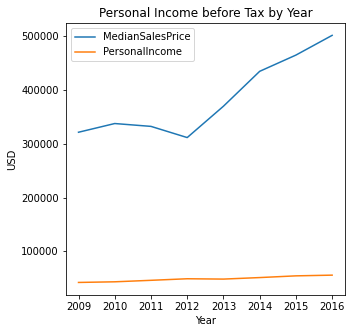

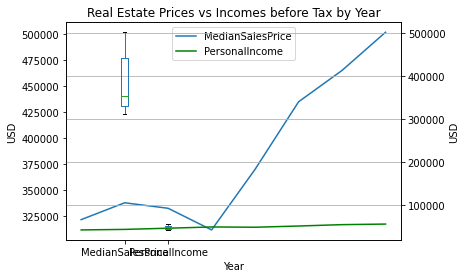

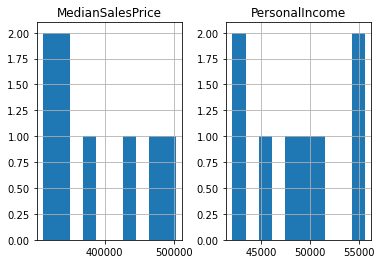

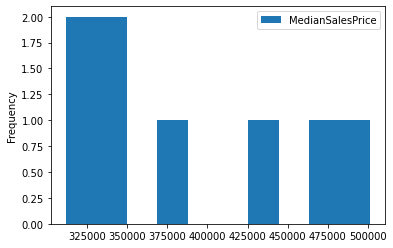

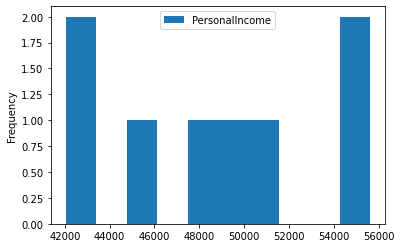

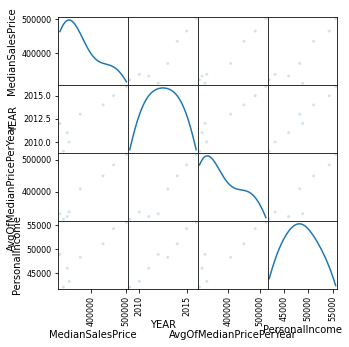

In [12]:
#### Visualization #######

### Pandas Visualization (Series and DataFrame is just a simple wrapper around Matplotlib)
# Create additional variable based on dataframe to time-series to make plotting more natural 
# (i.e. axis labels picked up naturally), as well as perform some statistical operations
tsLAPI = dfLosAngelesPricesAndIncomes.set_index('YEAR')


#dfLosAngelesPricesAndIncomes.plot()
lg1 = tsLAPI['MedianSalesPrice'].plot(title="Median Sales Price by Year", kind="line", \
      legend=True, figsize = (5,5))
lg1.set(xlabel='Year', ylabel='USD')

lg2 = tsLAPI['PersonalIncome'].plot(title="Personal Income before Tax by Year", kind="line", \
      legend=True,  figsize = (5,5))
lg2.set(xlabel='Year', ylabel='USD')


plt.figure()

plotResult = dfLosAngelesPricesAndIncomes.MedianSalesPrice.plot()
dfLosAngelesPricesAndIncomes.PersonalIncome.plot(secondary_y=True, style='g')
plotResult.set_xlabel('Year')

plotResult.set_title("Real Estate Prices vs Incomes before Tax by Year")
plotResult.set_ylabel('USD')
plotResult.right_ax.set_ylabel('USD')

#due to matplot being wrapped in
lines = plotResult.get_lines() + plotResult.right_ax.get_lines()
plotResult.legend(lines, [l.get_label() for l in lines], loc='upper center')
#plotResult.legend(['MedianSalesPrice', 'PersonalIncome'])


#look at the distribution of data
dfLosAngelesPricesAndIncomes[['MedianSalesPrice', 'PersonalIncome']].boxplot()
dfLosAngelesPricesAndIncomes[['MedianSalesPrice', 'PersonalIncome']].hist()


dfLosAngelesPricesAndIncomes[['MedianSalesPrice', 'YEAR']].plot(kind="hist", \
                            x="YEAR", y="MedianSalesPrice")

dfLosAngelesPricesAndIncomes[['PersonalIncome', 'YEAR']].plot(kind="hist", \
                            x="YEAR", y="PersonalIncome")


#Statistically
dfLosAngelesPricesAndIncomes[['MedianSalesPrice', 'PersonalIncome']].corr()

pearsonr(dfLosAngelesPricesAndIncomes['MedianSalesPrice'], dfLosAngelesPricesAndIncomes['PersonalIncome'])


### scatter_matrix
scatter_matrix(dfLosAngelesPricesAndIncomes, alpha=0.2, figsize=(5, 5), diagonal='kde')